# Capstone Project - The Battle of Neighborhoods (Week 2)

## ***IBM Data Science || Applied Data Science***

### Coursera

 ### London Neighborhood Clustering
 
 
 # Author : Nitesh Ranjan Singh





## Introduction

This project aims to select the safest borough in London based on the total crimes, explore the neighborhoods of that borough to find the 10 most common venues in each neighborhood and finally cluster the neighborhoods using k-mean clustering.

This report will be targeted to people who are looking to relocate to London. Inorder to finalise a neighborhood to hunt for an apartment, safety is considered as a top concern when moving to a new place. If you don’t feel safe in your own home, you’re not going to be able to enjoy living there. The crime statistics will provide an insight into this issue.

We will focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected.

## Data

Based on definition of our problem, factors that will influence our decision are:

The total number of crimes commited in each of the borough during the last year.

The most common venues in each of the neighborhood in the safest borough selected.

Following data sources will be needed to extract/generate the required information:

Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016: A dataset consisting of the crime statistics of each borough in London obtained from Kaggle

Part 2: Scraping additional information of the different Boroughs in London from a Wikipedia page.: More information regarding the boroughs of London is scraped using the Beautifulsoup library.

Part 3: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.: Co-ordinate of neighborhood will be obtained using Google Maps API geocoding

# Part 1: Preprocessing

### London Crime Data
#### About this file

lsoa_code: code for Lower Super Output Area in Greater London.

borough: Common name for London borough.

major_category: High level categorization of crime.

minor_category: Low level categorization of crime within major category.
value: monthly reported count of categorical crime in given borough.

year: Year of reported counts, 2008-2016

month: Month of reported counts, 1-12

Data set URL: https://www.kaggle.com/jboysen/london-crime

In [55]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### Foursquare Credentials

In [56]:
CLIENT_ID = 'YLLK2TQQ34NQFAY4BBM5Q3LCOSF2R5G03KOHDGEQCWQ3AJS1' # your Foursquare ID
CLIENT_SECRET = '3MJ2EM0UDEOLPEMB5TDUCNC5RTRXVIKY35YKO14GPGI0WHJR' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YLLK2TQQ34NQFAY4BBM5Q3LCOSF2R5G03KOHDGEQCWQ3AJS1
CLIENT_SECRET:3MJ2EM0UDEOLPEMB5TDUCNC5RTRXVIKY35YKO14GPGI0WHJR


In [57]:
# Read in the data 
df = pd.read_csv("london_crime_by_lsoa.csv")

c:\users\dell\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [58]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [59]:
df.shape

(1048575, 7)

In [60]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [61]:
df.shape

(26792, 7)

In [62]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [63]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [64]:
df.describe()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
count,26792,26792,26792,26792,26792,26792,26792
unique,4736,33,7,28,51,1,12
top,E01004736,Lambeth,Theft and Handling,Harassment,1,2016,10
freq,28,1226,8784,2509,16767,26792,2347


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26792 entries, 0 to 26791
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   LSOA_Code       26792 non-null  object
 1   Borough         26792 non-null  object
 2   Major_Category  26792 non-null  object
 3   Minor_Category  26792 non-null  object
 4   No_of_Crimes    26792 non-null  object
 5   Year            26792 non-null  object
 6   Month           26792 non-null  object
dtypes: object(7)
memory usage: 732.7+ KB


In [66]:
df.isnull().sum()

LSOA_Code         0
Borough           0
Major_Category    0
Minor_Category    0
No_of_Crimes      0
Year              0
Month             0
dtype: int64

In [50]:
#total no. crime in each Borough

df['Borough'].value_counts()

Lambeth                   1226
Southwark                 1136
Newham                    1085
Croydon                   1066
Ealing                    1057
Tower Hamlets             1050
Brent                     1009
Hackney                   1001
Haringey                   981
Barnet                     960
Lewisham                   946
Enfield                    943
Wandsworth                 924
Greenwich                  895
Westminster                890
Camden                     884
Hillingdon                 870
Islington                  868
Hounslow                   847
Waltham Forest             840
Redbridge                  807
Bromley                    788
Hammersmith and Fulham     717
Kensington and Chelsea     684
Havering                   664
Barking and Dagenham       638
Bexley                     580
Merton                     561
Harrow                     559
Sutton                     479
Richmond upon Thames       465
Kingston upon Thames       365
City of 

In [67]:
df['Major_Category'].value_counts()

Theft and Handling             8784
Violence Against the Person    8514
Criminal Damage                3282
Burglary                       2929
Drugs                          1524
Robbery                         970
Other Notifiable Offences       789
Name: Major_Category, dtype: int64

#### Pivoting the table to view the no. of crimes for each major category in each Borough

In [68]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham           93             130    51   
Barnet                        232             154    57   
Bexley                         70             129    58   
Brent                         198             154   136   
Bromley                       147             134    56   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                        28      33                336   
Barnet                                      37      24                628   
Bexley                                      17       9                319   
Brent                                       37      48                591   
Bromley                                     30      19                487   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                         412  
Barnet                                       514  
Bexley                                       312  
Brent                                        596  
Bromley                                      428

In [69]:
London_crime.reset_index(inplace=True)

In [70]:
# Total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(20)

Borough No_of_Crimes                        \
Major_Category                             Burglary Criminal Damage Drugs   
0                 Barking and Dagenham           93             130    51   
1                               Barnet          232             154    57   
2                               Bexley           70             129    58   
3                                Brent          198             154   136   
4                              Bromley          147             134    56   
5                               Camden          177             163   166   
6                       City of London            0               0     0   
7                              Croydon          140             211    86   
8                               Ealing          151             196    82   
9                              Enfield          146             107    78   
10                           Greenwich          122             183    66   
11                             Hackney          167             123   105   
12              Hammersmith and Fulham           89             134    73   
13                            Haringey          143             131   129   
14                              Harrow          107              94    34   
15                            Havering          136              95    61   
16                          Hillingdon          151             153    91   
17                            Hounslow          142             146    86   
18                           Islington          179             117   138   
19              Kensington and Chelsea           95              79   136   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                     28      33                336   
1                                     37      24                628   
2                                     17       9                319   
3                                     37      48                591   
4                                     30      19                487   
5                                     31      72                804   
6                                      0       2                  5   
7                                     41      53                724   
8                                     37      57                677   
9                                     39      55                583   
10                                    22      43                527   
11                                    34      63                786   
12                                    25      25                675   
13                                    41      74                735   
14                                    21      22                325   
15                                    29      21                392   
16                                    32      41                593   
17                                    44      22                534   
18                                    48      64                714   
19                                    17      38                726   

                                           Total  
Major_Category Violence Against the Person        
0                                      412  1083  
1                                      514  1646  
2                                      312   914  
3                                      596  1760  
4                                      428  1301  
5                                      541  1954  
6                                        1     8  
7                                      710  1965  
8                                      672  1872  
9                                      539  1547  
10                                     591  1554  
11                                     631  1909  
12                                     397  1418  
13      

#### Removing the multi index so that it will be easier to merge

In [71]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,93,130,51,28,33,336,412,1083
1,Barnet,232,154,57,37,24,628,514,1646
2,Bexley,70,129,58,17,9,319,312,914
3,Brent,198,154,136,37,48,591,596,1760
4,Bromley,147,134,56,30,19,487,428,1301


In [72]:
London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,93,130,51,28,33,336,412,1083
1,Barnet,232,154,57,37,24,628,514,1646
2,Bexley,70,129,58,17,9,319,312,914
3,Brent,198,154,136,37,48,591,596,1760
4,Bromley,147,134,56,30,19,487,428,1301


In [73]:
London_crime.shape

(33, 9)

In [74]:
# View the Columns in the data frame
London_crime.columns.tolist()

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total']

Part 2: Scraping additional information of the different Boroughs in London from a Wikipedia page 

Using Beautiful soup to scrap the latitude and longitiude of the boroughs in London

URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

In [116]:
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"033874e9-3ad5-4dae-a188-15d316599cc0","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":958873870,"wgRevisionId":958873870,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of 

In [117]:
# extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

In [118]:
# converting the data into table
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [119]:
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [120]:
# A continuous index value will be maintained 
# across the rows in the new appended data frame. 

London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [121]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [122]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2013 est)[1]  33 non-null     int64  
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.7+ KB


In [123]:
# Removing Unnecessary string in the Data set
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [124]:
type(London_table)

pandas.core.frame.DataFrame

In [125]:
# Shape of the data frame
London_table.shape

(33, 10)

In [126]:
# check if the borough in the both data frames match
set(df.Borough) - set(London_table.Borough)

# all match

set()

In [190]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barnet,232,154,57,37,24,628,514,1646,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
1,Bexley,70,129,58,17,9,319,312,914,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
2,Brent,198,154,136,37,48,591,596,1760,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
3,Bromley,147,134,56,30,19,487,428,1301,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
4,Camden,177,163,166,31,72,804,541,1954,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11


In [128]:
Ld_crime.shape

(30, 18)

In [129]:
set(df.Borough) - set(Ld_crime.Borough)

set()

In [130]:
# List of Column names of the data frame 
list(Ld_crime)

[]

In [131]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,232,154,57,37,24,628,514,1646
1,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,70,129,58,17,9,319,312,914
2,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,198,154,136,37,48,591,596,1760
3,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,147,134,56,30,19,487,428,1301
4,Camden,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,177,163,166,31,72,804,541,1954


### Methodology 

The methodology in this project consists of two parts:

1.)Exploratory Data Analysis: Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.

2.)Modelling: To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.

## Exploratory Data Analysis(EDA)

In [132]:
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,137.242424,132.969697,85.333333,30.969697,44.181818,606.121212,484.696970,1521.515152
std,49.477918,44.057125,50.658579,13.375549,27.881955,309.912262,178.707597,608.764020
min,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,1.000000,8.000000
25%,99.000000,100.000000,57.000000,21.000000,22.000000,392.000000,397.000000,1158.000000
50%,142.000000,134.000000,78.000000,31.000000,43.000000,591.000000,514.000000,1554.000000
75%,176.000000,154.000000,129.000000,41.000000,63.000000,735.000000,618.000000,1909.000000
max,232.000000,211.000000,235.000000,60.000000,115.000000,1790.000000,759.000000,3249.000000


In [133]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.3.0


In [191]:
#Ld_crime.columns = list(map(str, Ld_crime.columns))

# let's check the column labels types now
#all(isinstance(column, str) for column in Ld_crime.columns)

In [114]:
Ld_crime

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,93,130,51,28,33,336,412,1083
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,232,154,57,37,24,628,514,1646
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,70,129,58,17,9,319,312,914
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,198,154,136,37,48,591,596,1760
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,147,134,56,30,19,487,428,1301
5,Camden,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,177,163,166,31,72,804,541,1954
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,0,0,0,0,2,5,1,8
7,Croydon,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,140,211,86,41,53,724,710,1965
8,Ealing,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,151,196,82,37,57,677,672,1872
9,Enfield,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,146,107,78,39,55,583,539,1547


In [113]:
Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,93,130,51,28,33,336,412,1083
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,232,154,57,37,24,628,514,1646
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,70,129,58,17,9,319,312,914
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,198,154,136,37,48,591,596,1760
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,147,134,56,30,19,487,428,1301


In [135]:
# Sort the total crimes in descenting order to see 5 boroughs with the highest number of crimes
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
29,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,176,191,158,60,115,1790,759,3249
18,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,204,181,235,43,84,845,716,2308
21,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,148,180,135,51,81,1041,608,2244
24,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,209,194,132,47,52,909,667,2210
26,Tower Hamlets,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,196,153,109,46,94,803,618,2019


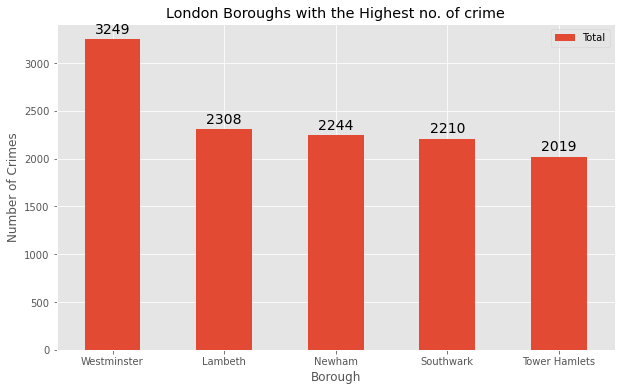

In [136]:
# Visualize the five boroughs with the highest number of crimes
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()


In [137]:
# Sort the total crimes in ascending order to see 5 boroughs with the highest number of crimes
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
5,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,0,0,0,0,2,5,1,8
17,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,65,65,34,13,4,217,207,605
23,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,87,91,16,11,3,296,206,710
25,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,77,98,24,13,13,246,267,738
11,Harrow,Harrow London Borough Council,Labour,"Civic Centre, Station Road",19.49,243372,51°35′23″N 0°20′05″W﻿ / ﻿51.5898°N 0.3346°W,107,94,34,21,22,325,264,867


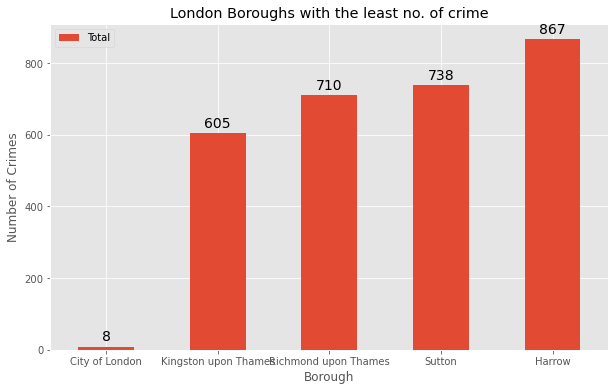

In [138]:
# Visualize the five boroughs with the least number of crimes
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

In [139]:
# The borough (City of London) has the lowest no. of crimes recorded for the year 2016, Looking into the details of the borough:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
5,City of London,8,1.12,7000


#### As per the wikipedia page, The City of London is the 33rd principal division of Greater London but it is not a London borough.

URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

Hence we will focus on the next borough with the least crime i.e. Kingston upon Thames

## Visualizing different types of crimes in the borough 'Kingston upon Thames'

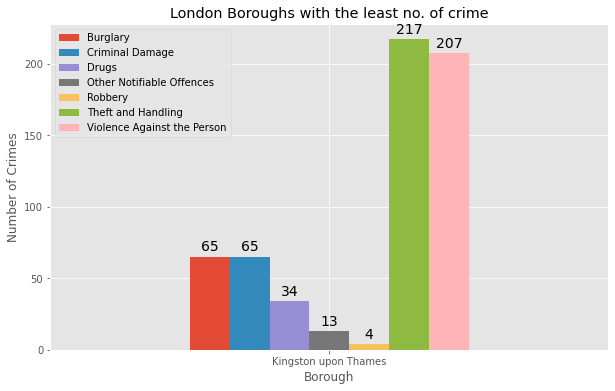

In [140]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

#### We can conclude that Kingston upon Thames is the safest borough when compared to the other boroughs in London.

## Part 3: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates. 

The list of Neighborhoods in the Royal Borough of Kingston upon Thames was found on a wikipedia page: https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames

In [142]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


####  Find the Co-ordiantes of each Neighborhood in the Kingston upon Thames Neighborhood

In [143]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [144]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


#### Get the co-ordinates of Berrylands, London, United Kingdom (The center neighborhood of Kingston upon Thames)

In [147]:

address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


In [148]:
# Visualize the Neighborhood of Kingston upon Thames Borough
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

## Modelling 

#### Finding all the venues within a 500 meter radius of each neighborhood.

Perform one hot ecoding on the venues data.

Grouping the venues by the neighborhood and calculating their mean.

Performing a K-means clustering (Defining K = 5)

#### Create a function to extract the venues from each Neighborhood

In [158]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [159]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [160]:
print(kut_venues.shape)
kut_venues.head()

(179, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Berrylands,51.393781,-0.284802,Cafe Rosa,51.390175,-0.282490,Café
4,Berrylands,51.393781,-0.284802,Kamala Food and Wine,51.397810,-0.284045,Wine Shop


In [161]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,5,5,5,5,5,5
Canbury,14,14,14,14,14,14
Chessington,1,1,1,1,1,1
Hook,5,5,5,5,5,5
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,7,7,7,7,7,7


In [162]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 69 uniques categories.


#### One hot encoding
URL: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [167]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
#fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
#kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Bistro,Bookstore,Bowling Alley,Breakfast Spot,...,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Berrylands
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Berrylands
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Berrylands
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Berrylands
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Berrylands


In [168]:
col_name="Neighborhood"
first_col = kut_onehot.pop(col_name)

In [169]:
kut_onehot.insert(0, col_name, first_col)

In [170]:
kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Bistro,Bookstore,Bowling Alley,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [172]:
# Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Bistro,Bookstore,Bowling Alley,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.071429,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Chessington,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hook,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kingston upon Thames,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.000000
6,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,New Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000
9,Norbiton,0.000000,0.033333,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333


In [173]:
kut_grouped.shape

(14, 70)

In [174]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0             Wine Shop   0.2
1                  Park   0.2
2  Gym / Fitness Center   0.2
3                  Café   0.2
4              Bus Stop   0.2


----Canbury----
                  venue  freq
0                   Pub  0.29
1           Supermarket  0.07
2  Gym / Fitness Center  0.07
3                  Park  0.07
4     Fish & Chips Shop  0.07


----Chessington----
              venue  freq
0              Park   1.0
1  Asian Restaurant   0.0
2            Market   0.0
3          Platform   0.0
4       Pizza Place   0.0


----Hook----
               venue  freq
0                Pub   0.2
1             Bakery   0.2
2  Indian Restaurant   0.2
3        Supermarket   0.2
4  Fish & Chips Shop   0.2


----Kingston Vale----
            venue  freq
0   Grocery Store  0.25
1    Soccer Field  0.25
2             Bar  0.25
3  Sandwich Place  0.25
4     Pizza Place  0.00


----Kingston upon Thames----
              venue  freq
0       Coffee Shop  0.

### Create a data frame of the venues

**Function to sort the venues in descending order.**

In [175]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe and display the top 10 venues for each neighborhood

In [176]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Wine Shop,Gym / Fitness Center,Park,Café,Bus Stop,Farmers Market,Department Store,Dry Cleaner,Electronics Store,Fast Food Restaurant
1,Canbury,Pub,Park,Fish & Chips Shop,Supermarket,Spa,Café,Shop & Service,Gym / Fitness Center,Plaza,Hotel
2,Chessington,Park,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop,Convenience Store
3,Hook,Fish & Chips Shop,Pub,Bakery,Supermarket,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store
4,Kingston Vale,Grocery Store,Sandwich Place,Bar,Soccer Field,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market



## Clustering similar neighborhoods together using k - means clustering

In [177]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 0, 1, 2, 1, 2, 3, 1, 1])

In [178]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3.0,Wine Shop,Gym / Fitness Center,Park,Café,Bus Stop,Farmers Market,Department Store,Dry Cleaner,Electronics Store,Fast Food Restaurant
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1.0,Pub,Park,Fish & Chips Shop,Supermarket,Spa,Café,Shop & Service,Gym / Fitness Center,Plaza,Hotel
2,Chessington,Kingston upon Thames,51.358336,-0.298622,0.0,Park,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop,Convenience Store
3,Coombe,Kingston upon Thames,51.419450,-0.265398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hook,Kingston upon Thames,51.367898,-0.307145,1.0,Fish & Chips Shop,Pub,Bakery,Supermarket,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store


In [179]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          14 non-null     float64
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

In [180]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [181]:
kut_merged.shape

(14, 15)

In [182]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [183]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            14 non-null     object 
 1   Borough                 14 non-null     object 
 2   Latitude                14 non-null     float64
 3   Longitude               14 non-null     float64
 4   Cluster Labels          14 non-null     int32  
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

In [184]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters


Each cluster is color coded for the ease of presentation, we can see that majority of the neighborhood falls in the red cluster which is the first cluster. Three neighborhoods have their own cluster (Blue, Purple and Yellow), these are clusters two three and five. The green cluster consists of two neighborhoods which is the 4th cluster.

## Analysis 
Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

Examine the first cluster

In [185]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Chessington,Kingston upon Thames,51.358336,-0.298622,0,Park,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop,Convenience Store


In [186]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1,Pub,Park,Fish & Chips Shop,Supermarket,Spa,Café,Shop & Service,Gym / Fitness Center,Plaza,Hotel
4,Hook,Kingston upon Thames,51.367898,-0.307145,1,Fish & Chips Shop,Pub,Bakery,Supermarket,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,1,Coffee Shop,Pub,Sushi Restaurant,Café,Burger Joint,Asian Restaurant,Department Store,Gym / Fitness Center,Market,Mexican Restaurant
9,New Malden,Kingston upon Thames,51.405335,-0.263407,1,Korean Restaurant,Gastropub,Sushi Restaurant,Supermarket,Bar,Indian Restaurant,Wine Shop,Farmers Market,Deli / Bodega,Department Store
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,1,Indian Restaurant,Food,Italian Restaurant,Pub,Wine Shop,Japanese Restaurant,Hotel,Hardware Store,Fried Chicken Joint,Dry Cleaner
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,1,Indian Restaurant,Coffee Shop,Pub,Restaurant,Pet Café,Chinese Restaurant,Café,Italian Restaurant,Park,Harbor / Marina
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,1,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Pharmacy,Thai Restaurant,Tea Room,Gastropub,Train Station,Farmers Market


In [187]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138,2,Grocery Store,Sandwich Place,Bar,Soccer Field,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,2,Grocery Store,Garden Center,Pub,Restaurant,Electronics Store,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Farmers Market
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,2,Grocery Store,Restaurant,Pharmacy,Café,Train Station,Hotel,Indian Restaurant,Italian Restaurant,Coffee Shop,Furniture / Home Store


In [188]:

kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3,Wine Shop,Gym / Fitness Center,Park,Café,Bus Stop,Farmers Market,Department Store,Dry Cleaner,Electronics Store,Fast Food Restaurant
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,3,Gym,Park,Bus Stop,Soccer Field,Wine Shop,Farmers Market,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store


In [189]:

kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Old Malden,Kingston upon Thames,51.382484,-0.25909,4,Train Station,Pub,Food,Construction & Landscaping,Farmers Market,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store


# Results and Discussion 
The aim of this project is to help people who want to relocate to the safest borough in London, expats can chose the neighborhoods to which they want to relocate based on the most common venues in it. For example if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Train stations and Bus stops as the most common venues. If a person is looking for a neighborhood with stores and restaurants in a close proximity then the neighborhoods in the first cluster is suitable. For a family I feel that the neighborhoods in Cluster 4 are more suitable dues to the common venues in that cluster, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields which is ideal for a family.

# Conclusion 
This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood. It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood. We have just taken safety as a primary concern to shortlist the borough of London. The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the borough based on safety and a predefined budget.

### ***Thank you***